<h1 style="text-align: center;">Stroke Prediction</h1>

<h3 style="text-align: center;">2. Models Comparison</h3>

<p style="text-align: center;">Hugo Gálvez</p>

## Models Selection

In this study we have decided to limit the evaluation to four types of models: **Decision Trees**, **Random Forest**, **XGBoost** and **Artificial Neural Networks (ANN)**, based on criteria of interpretability, performance and applicability to the medical context.

Among the machine learning models excelling in stroke prediction, `XGBoost` has demonstrated great performance due to its ability to handle large-scale datasets, and capture complex nonlinear relationships among variables, achieving great scores in the stroke prediction problem (Chen & Guestrin, 2016; Emon et al., 2020). `Random Forest` remains a reliable choice, and has been widely used in medical applications, but has shown moderate performance in the stroke context (Kokkotis, et al., 2022). `Decision Trees`, while simpler and less performant in complex datasets, offer unparalleled transparency, and have proven to outperform deep learning models on typical tabular data (Grinsztajn et al., 2022). 

 `Neural Networks (NNs)` have consistently outperformed traditional models in capturing complex interactions (Dev et al., 2022). A notable innovation includes the Weighted Voting method, which aggregates predictions from multiple models like K-Nearest Neighbors, Decision Trees, AdaBoost, and XGBoost. This hybrid approach achieved an accuracy of 97%, demonstrating the potential of ensemble techniques (Emon et al., 2020). Meanwhile, the Multi-Layer Perceptron (MLP) classifier has also shown remarkable success, outperforming models like K-Nearest Neighbors, Support Vector Machines and XGBoost (Kokkotis et al., 2022).

Consequently, the use of these four approaches is prioritized for their balance between technical performance, advanced capabilities and practical needs in the healthcare context, ensuring useful and actionable results for medical professionals.

In [1]:
# General
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# Scikit-learn: preprocessing, models and metrics
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (StandardScaler, OneHotEncoder, LabelEncoder)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, make_scorer, roc_curve, confusion_matrix,
    classification_report
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Imbalanced-learn: SMOTENC and pipelines
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTENC

# XGBoost
from xgboost import XGBClassifier

# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

Before starting, we use the command `pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118` to install `PyTorch` and `CUDA` 11.8 to perform the operations and run/train models on GPU (ANN).

We check that the GPU is detected correctly:

In [2]:
torch.cuda.is_available()

True

We performed a small “*benchmark*” to check GPU usage:

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# Creation and multiplication of tensors
size = 10000
a = torch.randn(size, size, device=device)
b = torch.randn(size, size, device=device)

# Benchmark
if device.type == 'cuda':
    torch.cuda.synchronize()
start_time = time.time()
c = torch.matmul(a, b)
if device.type == 'cuda':
    torch.cuda.synchronize()

# Results
print(f"Execution time in "+
      f"{device}: {time.time() - start_time:.4f} seconds")
print(f"The result is in: {c.device}")

Usando dispositivo: cuda
Execution time in cuda: 0.1321 seconds
The result is in: cuda:0


We import our previously cleaned data.

In [4]:
# Load data
data = pd.read_csv('cleaned_healthcare_dataset.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4886 entries, 0 to 4885
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4886 non-null   bool   
 1   age                4886 non-null   float64
 2   hypertension       4886 non-null   bool   
 3   heart_disease      4886 non-null   bool   
 4   ever_married       4886 non-null   bool   
 5   work_type          4886 non-null   object 
 6   Residence_type     4886 non-null   bool   
 7   avg_glucose_level  4886 non-null   float64
 8   bmi                4886 non-null   float64
 9   smoking_status     4886 non-null   object 
 10  stroke             4886 non-null   bool   
dtypes: bool(6), float64(3), object(2)
memory usage: 219.6+ KB


In previous analyses we verified that our data has a significant imbalance, so we will use the `imbalanced-learn` library to generate synthetic samples of the minority class. Before that, to avoid data leakage, we will split the data into *train* and *test*.

## Obtaining of *train* and *test* samples

In [5]:
seed = 12345

# Separate the characteristics and the target variable
X = data.drop(columns=['stroke'])
y = data['stroke']

# Split data into training (67%) and test (33%) seed = 12345
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,
                                                    random_state=seed,
                                                    stratify=y)

# Show the dimensions of the assemblies
print(f"Sizes: X_train: {X_train.shape}, X_test: {X_test.shape}, "
      f"y_train: {y_train.shape}, y_test: {y_test.shape}.")

Sizes: X_train: (3273, 10), X_test: (1613, 10), y_train: (3273,), y_test: (1613,).


We next implement data preprocessing and cross-validation setup to evaluate the models with a rigorous and clinically appropriate approach.

#### Data Preprocessing
The dataset contains **categorical and numerical** variables. The preprocessor uses:
- `StandardScaler` to normalize numerical features, ensuring all have a mean of zero and a standard deviation of one. This is crucial to improving the performance of algorithms that depend on data scaling.
- `OneHotEncoder` to encode categorical features into binary variables, ensuring that models can process them correctly without imposing implicit ordinal relationships.

#### Class Balancing with SMOTENC
The use of `SMOTENC` **(Synthetic Minority Oversampling Technique for Nominal and Continuous variables)** is critical in this analysis due to the significant class imbalance, where stroke patients represent the minority class. `SMOTENC` generates synthetic samples while considering both categorical and numerical features of the training set, preserving the integrity of the test set and preventing data leakage. This approach, widely recognized in medical and technical literature, enhances model performance in imbalanced scenarios.

#### Cross-Validation and Metrics
Stratified cross-validation (`StratifiedKFold`) with 5 folds was used to ensure that each subset maintains similar class proportions, which is essential for imbalanced datasets. This method allows for a more robust and generalizable evaluation of model performance.

The selected metrics for model evaluation include:
- `Recall`: Prioritized in clinical contexts to minimize false negatives.
- `Precision`, `F1-Score`, and `ROC-AUC`: Provide a balanced view of model performance, considering both accurate classification of positive cases and class discrimination.

#### Pipeline Creation
A pipeline was created to automate preprocessing, class balancing with `SMOTENC`, and model integration, ensuring consistency and reproducibility in each cross-validation iteration. This modular approach facilitates the comparison and tuning of different algorithms.

This configuration ensures rigorous and well-founded analysis aligned with best practices in machine learning for clinical problems.

In [6]:
# Define the categorical and numerical columns
categorical_features = [
    'gender', 'hypertension', 'heart_disease', 'ever_married', 
    'work_type', 'Residence_type', 'smoking_status'
]
numerical_features = ['age', 'avg_glucose_level', 'bmi']

# Create preprocessor with OneHotEncoder for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

categorical_indices = [i for i, feature in enumerate(numerical_features + categorical_features) 
                      if feature in categorical_features]

# Function to build the pipeline with SMOTENC
def create_pipeline(model):
    return ImbPipeline([
        ('preprocessor', preprocessor),
        ('smotenc', SMOTENC(random_state=seed, categorical_features=categorical_indices)),
        ('model', model)
    ])

# Cross validation configuration
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# Define metrics for cross-validation
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted',
                             zero_division=1),
    'recall': make_scorer(recall_score, average='weighted',
                          zero_division=1),
    'f1': make_scorer(f1_score, average='weighted'),
    'roc_auc': 'roc_auc'
}

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame()
# Dictionary for storing classification reports
classification_reports = {}

The `evaluate_model` function evaluates traditional models and neural networks (ANN) through cross-validation and final testing, calculating key metrics such as `Accuracy`, `Precision`, `Recall`, `F1-Score`, and `ROC-AUC`.

For neural networks, it configures specific data loaders (**PyTorch/TensorFlow**), performs manual cross-validation, and handles hyperparameters like layers and epochs. For traditional models, it employs pipelines with preprocessing, **SMOTENC**, and automated cross-validation.

Additionally, it visualizes ROC curves and saves results in a structured format to facilitate comparisons. This approach balances technical rigor and practicality, optimizing models for a clinically sensitive context.

In [7]:
def evaluate_model(model,
                   X_train, y_train,
                   X_test, y_test,
                   cv, scoring, preprocessor, results_list,
                   skip_cv_metrics=None, model_name=None,
                   categorical_features=None,
                   reports_dict=None):
    """
    Evalúa un modelo con validación cruzada y en un conjunto de prueba,
    soportando ANN (solo TensorFlow) y modelos tradicionales utilizando SMOTENC.
    """
    skip_cv_metrics = skip_cv_metrics or []
    model_name = model_name or (
        model['name'] if isinstance(model, dict) else type(model).__name__)

    if isinstance(model, dict) and 'layers' in model:
        # TensorFlow ANN
        accuracies, precisions, recalls, f1_scores, aucs = [], [], [], [], []
        for train_idx, val_idx in cv.split(X_train, y_train):
            X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

            # Preprocessing
            X_cv_train_transformed = preprocessor.fit_transform(X_cv_train)
            X_cv_val_transformed = preprocessor.transform(X_cv_val)

            # SMOTENC
            smotenc = SMOTENC(random_state=seed,
                              categorical_features=categorical_indices)
            X_cv_train_res, y_cv_train_res = smotenc.fit_resample(
                X_cv_train_transformed, y_cv_train)

            # Training and validation TensorFlow ANN
            input_dim = X_cv_train_res.shape[1]
            ann_model = build_and_train_model(
                X_cv_train_res, y_cv_train_res,
                model['layers'], model['epochs'],
                model['batch_size'], model['dropout_rate'], input_dim
            )
            y_val_proba = ann_model.predict(X_cv_val_transformed).flatten()
            y_val_pred = (y_val_proba > 0.5).astype(int)
            y_val_true = y_cv_val

            # Calculate metrics
            accuracies.append(accuracy_score(y_val_true, y_val_pred))
            precisions.append(precision_score(y_val_true, y_val_pred,
                                              average='weighted',
                                              zero_division=1))
            recalls.append(recall_score(y_val_true, y_val_pred,
                                        average='weighted',
                                        zero_division=1))
            f1_scores.append(f1_score(y_val_true, y_val_pred,
                                      average='weighted'))
            aucs.append(roc_auc_score(y_val_true, y_val_proba))

        # Consolidate cross-validation metrics
        mean_results = {
            'Accuracy CV': np.mean(accuracies),
            'Precision CV': np.mean(precisions),
            'Recall CV': np.mean(recalls),
            'F1 CV': np.mean(f1_scores),
            'Roc_auc CV': np.mean(aucs)
        }

        # Preprocess and apply SMOTENC on the entire training set.
        X_train_transformed = preprocessor.fit_transform(X_train)
        X_train_res, y_train_res = SMOTENC(
            random_state=seed,
            categorical_features=categorical_indices).fit_resample(
                X_train_transformed, y_train)
        X_test_transformed = preprocessor.transform(X_test)

        # Training the ANN
        input_dim = X_train_res.shape[1]
        ann_model = build_and_train_model(
            X_train_res, y_train_res,
            model['layers'], model['epochs'],
            model['batch_size'], model['dropout_rate'], input_dim
        )
        y_test_proba = ann_model.predict(X_test_transformed).flatten()
        y_test_pred = (y_test_proba > 0.5).astype(int)
        y_test_true = y_test

        # Classification report
        classification_rep = classification_report(
            y_test_true,
            y_test_pred,
            output_dict=True,
            target_names=['False', 'True']
        )
        
        # Save the classification report in reports_dict
        if reports_dict is not None:
            reports_dict[model_name] = classification_rep

        # Save ROC curve data
        fpr, tpr, _ = roc_curve(y_test_true, y_test_proba)
        auc = roc_auc_score(y_test_true, y_test_proba)
        if model_name not in reports_dict:
            reports_dict[model_name] = {}
        reports_dict[model_name]["roc_curve"] = {
            "fpr": fpr.tolist(),
            "tpr": tpr.tolist(),
            "auc": auc
        }

    else:
        # Cross validation for other models using SMOTENC in the pipeline
        pipeline = ImbPipeline([
            ('preprocessor', preprocessor),
            ('smotenc', SMOTENC(random_state=seed,
                                categorical_features=categorical_indices)),
            ('model', model)
        ])
        filtered_scoring = {
            key: value for key,
            value in scoring.items() if key not in skip_cv_metrics}
        scores = cross_validate(pipeline,
                                X_train,
                                y_train, cv=cv,
                                scoring=filtered_scoring,
                                return_train_score=False)
        mean_results = {
            f"{metric.capitalize()} CV":
            scores[f'test_{metric}'].mean() if metric in filtered_scoring else None
                        for metric in ['accuracy',
                                       'precision',
                                       'recall',
                                       'f1',
                                       'roc_auc']}

        pipeline.fit(X_train, y_train)
        y_test_pred = pipeline.predict(X_test)
        y_test_proba = pipeline.predict_proba(X_test)[:, 1] if hasattr(
            pipeline, "predict_proba") else None
        y_test_true = y_test

        # Classification report
        classification_rep = classification_report(y_test_true, y_test_pred,
                                                   output_dict=True)
    
        # Save the classification report in reports_dict
        if reports_dict is not None:
            reports_dict[model_name] = classification_rep

        # Save ROC curve data
        if y_test_proba is not None:
            fpr, tpr, _ = roc_curve(y_test_true, y_test_proba)
            auc = roc_auc_score(y_test_true, y_test_proba)
            if model_name not in reports_dict:
                reports_dict[model_name] = {}
            reports_dict[model_name]["roc_curve"] = {
                "fpr": fpr.tolist(),
                "tpr": tpr.tolist(),
                "auc": auc
            }

    # Calculate test metrics
    test_results = {
        'Accuracy Test': accuracy_score(y_test_true, y_test_pred),
        'Precision Test': precision_score(y_test_true, y_test_pred,
                                          average='weighted', zero_division=1),
        'Recall Test': recall_score(y_test_true, y_test_pred,
                                    average='weighted', zero_division=1),
        'F1 Test': f1_score(y_test_true, y_test_pred, average='weighted'),
        'AUC-ROC Test': roc_auc_score(
            y_test_true, y_test_proba) if y_test_proba is not None else None,
        'Matriz de Confusión': confusion_matrix(
            y_test_true, y_test_pred).tolist()
    }

    # ROC
    if y_test_proba is not None:
        fpr, tpr, _ = roc_curve(y_test_true, y_test_proba)
        plt.plot(fpr, tpr, label=f'{model_name} - AUC: {
            test_results["AUC-ROC Test"]:.4f}')

    # Store results
    results_list.append({'Modelo': model_name, **mean_results, **test_results})

## Application of Algorithms

In this study, we will evaluate various `Machine Learning` models using a set of metrics to measure their performance. We will prioritize `ROC-AUC` as the primary criterion for selecting the most effective model. This metric, widely used in problems with imbalanced classes, measures the model's ability to distinguish between positive and negative classes across all possible classification thresholds. This is particularly relevant in our case due to the significant imbalance in the target variable's distribution (stroke).

After identifying the model with the best performance based on `ROC-AUC`, we will fine-tune its hyperparameters to optimize `recall`, a priority metric in this clinical context. `Recall` measures the model's ability to correctly identify all positive cases, minimizing false negatives. Given the critical nature of stroke, maximizing `recall` ensures that at-risk patients are identified in time, enabling timely and potentially life-saving medical interventions.

### Classification Trees

We will now implement two tree-based models: a simple `Decision Tree` and an `AdaBoost Decision Tree` using the `SAMME` algorithm, which enhances performance by combining multiple base trees. **Decision Tree** offers simplicity and ease of interpretation. **AdaBoost** boosts weak trees through adaptive boosting, making it ideal for capturing complex relationships.

The models are processed using `evaluate_model`, the metrics are stored in `tree_results_df`, and then concatenated into the global `results_df`.

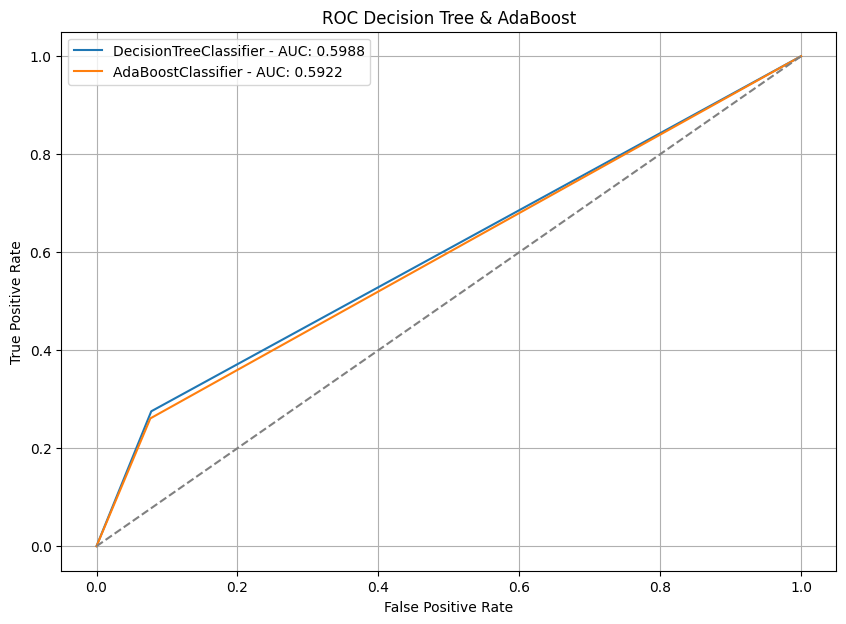

### Decision Tree & AdaBoost with Cross-validation & ROC/AUC Results

| Modelo                 |   Accuracy CV |   Precision CV |   Recall CV |    F1 CV |   Roc_auc CV |   Accuracy Test |   Precision Test |   Recall Test |   F1 Test |   AUC-ROC Test | Matriz de Confusión     |
|:-----------------------|--------------:|---------------:|------------:|---------:|-------------:|----------------:|-----------------:|--------------:|----------:|---------------:|:------------------------|
| DecisionTreeClassifier |      0.8836   |       0.926051 |    0.8836   | 0.903199 |     0.563897 |        0.894606 |         0.9306   |      0.894606 |  0.911119 |       0.598821 | [[1424, 120], [50, 19]] |
| AdaBoostClassifier     |      0.883291 |       0.92595  |    0.883291 | 0.902974 |     0.563736 |        0.895226 |         0.929832 |      0.895226 |  0.911186 |       0.592222 | [[1426, 118], [51, 18]] |

In [8]:
# Define models
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=seed),
    'AdaBoost Decision Tree': AdaBoostClassifier(
        estimator=DecisionTreeClassifier(random_state=seed), 
        random_state=seed, algorithm='SAMME'
    )
}

# List for results
tree_results = []

# ROC graph
plt.figure(figsize=(10, 7))

# Evaluate models
for name, model in models.items():
    evaluate_model(model, X_train, y_train, X_test, y_test,
                   cv, scoring, preprocessor, tree_results,
                   reports_dict=classification_reports)

# Show ROC graph
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Decision Tree & AdaBoost')
plt.legend()
plt.grid()
plt.show()

# Store results
tree_results_df = pd.DataFrame(tree_results)
display(Markdown("### Decision Tree & AdaBoost with "+
                 "Cross-validation & ROC/AUC Results"))
display(Markdown(tree_results_df.to_markdown(index=False)))

# Update global results
results_df = pd.concat([results_df, tree_results_df], ignore_index=True)

### Random Forest

With **Random Forest**, we evaluate models with different numbers of trees to compare their performance. Two Random Forest variants are created with 100 and 200 trees (`n_estimators`), configured with a fixed seed for reproducibility.

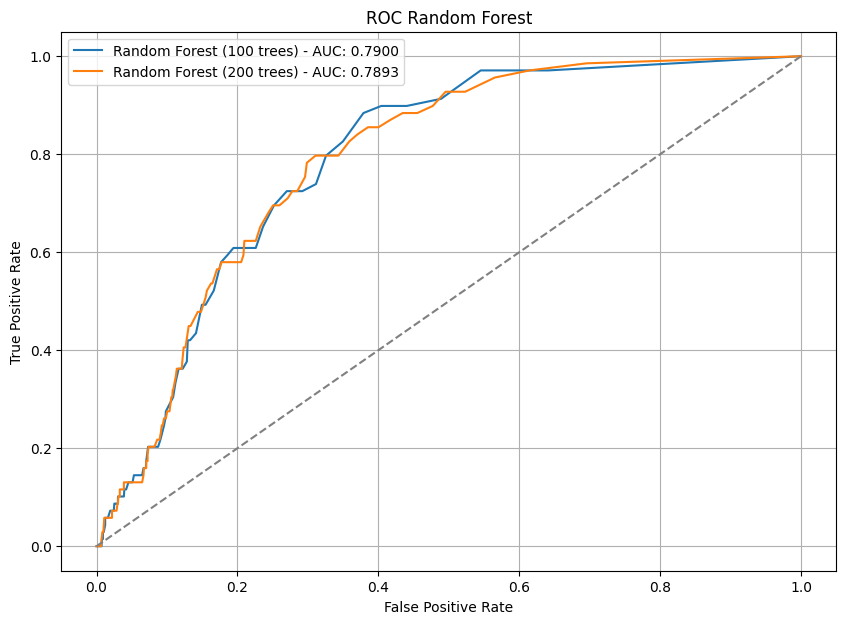

### Random Forest with Cross-validation & ROC/AUC Results

| Modelo                    |   Accuracy CV |   Precision CV |   Recall CV |    F1 CV |   Roc_auc CV |   Accuracy Test |   Precision Test |   Recall Test |   F1 Test |   AUC-ROC Test | Matriz de Confusión    |
|:--------------------------|--------------:|---------------:|------------:|---------:|-------------:|----------------:|-----------------:|--------------:|----------:|---------------:|:-----------------------|
| Random Forest (100 trees) |      0.907123 |       0.92633  |    0.907123 | 0.916297 |     0.77166  |        0.910725 |         0.924521 |      0.910725 |  0.917423 |       0.790019 | [[1459, 85], [59, 10]] |
| Random Forest (200 trees) |      0.906819 |       0.927209 |    0.906819 | 0.916496 |     0.771138 |        0.910725 |         0.923577 |      0.910725 |  0.916989 |       0.789292 | [[1460, 84], [60, 9]]  |

In [9]:
# Define models
models = {f'Random Forest ({n} trees)': RandomForestClassifier(n_estimators=n,
                                                               random_state=seed) 
          for n in [100, 200]}

# List for results
rf_results = []

# ROC graph
plt.figure(figsize=(10, 7))

# Evaluate models
for name, model in models.items():
    evaluate_model(
        model, 
        X_train, y_train, X_test, y_test, 
        cv=cv, scoring=scoring, 
        preprocessor=preprocessor, 
        results_list=rf_results, 
        model_name=name, reports_dict=classification_reports
    )

# Show ROC graph
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Random Forest')
plt.legend()
plt.grid()
plt.show()

# Store results
rf_results_df = pd.DataFrame(rf_results)
display(Markdown("### Random Forest with "+
                 "Cross-validation & ROC/AUC Results"))
display(Markdown(rf_results_df.to_markdown(index=False)))

# Update global results
results_df = pd.concat([results_df, rf_results_df], ignore_index=True)

### XGBoost

In this section, we evaluate the **XGBoost** model, an advanced boosting algorithm designed to enhance performance:

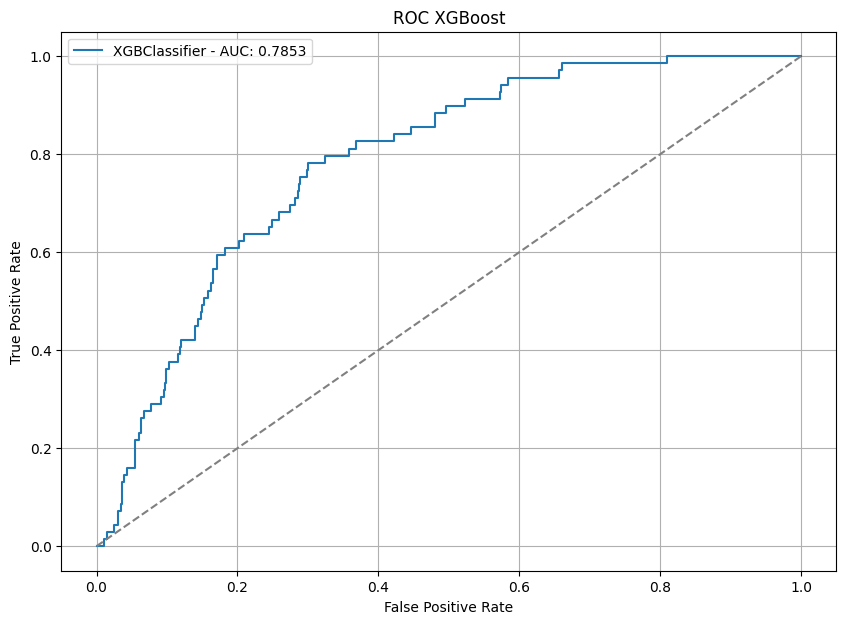

### XGBoost with Cross-validation & ROC/AUC Results

| Modelo        |   Accuracy CV |   Precision CV |   Recall CV |    F1 CV |   Roc_auc CV |   Accuracy Test |   Precision Test |   Recall Test |   F1 Test |   AUC-ROC Test | Matriz de Confusión     |
|:--------------|--------------:|---------------:|------------:|---------:|-------------:|----------------:|-----------------:|--------------:|----------:|---------------:|:------------------------|
| XGBClassifier |      0.882988 |       0.930119 |    0.882988 | 0.904375 |     0.756092 |        0.893986 |         0.931362 |      0.893986 |  0.911042 |       0.785303 | [[1422, 122], [49, 20]] |

In [10]:
# Define XGBoost model
xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    random_state=seed,
    eval_metric='logloss'
)

xgb_results = []

plt.figure(figsize=(10, 7))

evaluate_model(
    xgb_model, 
    X_train, y_train, X_test, y_test, 
    cv=cv, scoring=scoring, 
    preprocessor=preprocessor, 
    results_list=xgb_results, reports_dict=classification_reports
)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC XGBoost')
plt.legend()
plt.grid()
plt.show()

xgb_results_df = pd.DataFrame(xgb_results)
display(Markdown("### XGBoost with Cross-validation & ROC/AUC Results"))
display(Markdown(xgb_results_df.to_markdown(index=False)))

results_df = pd.concat([results_df, xgb_results_df], ignore_index=True)

### Artificial Neural Networks (ANN)

In this implementation, neural networks are built and trained to address the problem, using TensorFlow as the primary framework.

#### 1. Architecture Definition
The `build_and_train_model` function facilitates the construction and training of the model with key components:
- `Sequential`: Defines a linear flow of layers, ideal for dense networks.
- `Dense`: Creates fully connected layers, where each node is connected to all nodes in the previous layer.
- `ReLU` Activation: Introduces non-linearity to the model, enhancing its ability to learn complex patterns.
- `Dropout`: Reduces overfitting by randomly deactivating a percentage of nodes during training (`dropout_rate`).

The output layer uses:
- Sigmoid Activation: Converts the output into a probability between 0 and 1, essential for binary classification.

#### 2. Model Training
- `compile`:
  - Loss Function `binary_crossentropy`: Calculates the difference between predictions and actual values for binary problems, penalizing errors more heavily in imbalanced classes.
  - Adam Optimizer: Efficiently adjusts model weights using adaptive learning rates.
- `EarlyStopping`:
  - Monitors the loss to stop training when significant improvements are no longer observed, reducing unnecessary runtime.
  - Restores the best weights achieved during training.

These elements are designed to maximize model performance and stability, ensuring the training process adapts to our problem without overfitting.

Evaluando: ANN 50, 10 nodes
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Evaluando: ANN 100, 50, 10 nodes
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


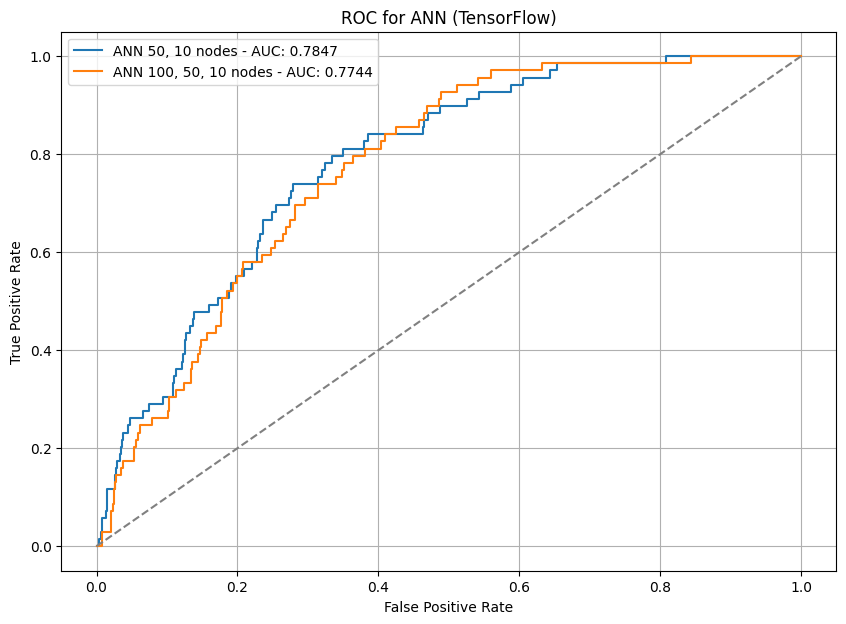

### ANN (TensorFlow) with Cross-validation & ROC/AUC Results

| Modelo                |   Accuracy CV |   Precision CV |   Recall CV |    F1 CV |   Roc_auc CV |   Accuracy Test |   Precision Test |   Recall Test |   F1 Test |   AUC-ROC Test | Matriz de Confusión     |
|:----------------------|--------------:|---------------:|------------:|---------:|-------------:|----------------:|-----------------:|--------------:|----------:|---------------:|:------------------------|
| ANN 50, 10 nodes      |      0.800491 |       0.93347  |    0.800491 | 0.855737 |     0.765085 |        0.789833 |         0.9385   |      0.789833 |  0.849618 |       0.784749 | [[1236, 308], [31, 38]] |
| ANN 100, 50, 10 nodes |      0.84846  |       0.930641 |    0.84846  | 0.88436  |     0.76275  |        0.841909 |         0.931961 |      0.841909 |  0.880847 |       0.774377 | [[1332, 212], [43, 26]] |

In [11]:
def build_and_train_model(X_train, y_train, layers, epochs,
                          batch_size, dropout_rate, input_dim):
    """
    Construye, entrena y devuelve un modelo de red neuronal usando TensorFlow.

    Parameters:
    - X_train: Datos de entrenamiento.
    - y_train: Etiquetas de entrenamiento.
    - layers: Lista con el número de nodos en cada capa oculta.
    - epochs: Número de épocas.
    - batch_size: Tamaño del batch.
    - dropout_rate: Tasa de dropout.
    - input_dim: Dimensión de entrada.

    Returns:
    - model: Modelo entrenado.
    """
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    for units in layers:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Binary output
    model.compile(optimizer=Adam(), loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Implement EarlyStopping
    early_stop = EarlyStopping(monitor='loss', patience=5,
                               restore_best_weights=True)

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
              verbose=0, callbacks=[early_stop])
    return model


# ANN arquitectures
architectures = {
    'ANN 50, 10 nodes': {'layers': [50, 10],
                         'epochs': 50,
                         'batch_size': 128,
                         'dropout_rate': 0.3,
                         'name': 'ANN 50, 10 nodes'},
    'ANN 100, 50, 10 nodes': {'layers': [100, 50, 10],
                              'epochs': 50,
                              'batch_size': 128,
                              'dropout_rate': 0.3,
                              'name': 'ANN 100, 50, 10 nodes'}
}

ann_results = []

# Create and evaluate models
plt.figure(figsize=(10, 7))
for name, params in architectures.items():
    print(f"Evaluando: {name}")
    evaluate_model(
        model=params,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test,
        cv=cv,
        scoring=scoring,
        preprocessor=preprocessor,
        results_list=ann_results,
        model_name=name,
        categorical_features=categorical_features,
        reports_dict=classification_reports
    )

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for ANN (TensorFlow)')
plt.legend()
plt.grid()
plt.show()

ann_results_df = pd.DataFrame(ann_results)
display(Markdown("### ANN (TensorFlow) with Cross-validation & ROC/AUC "+
                 "Results"))
display(Markdown(ann_results_df.to_markdown(index=False)))

results_df = pd.concat([results_df, ann_results_df], ignore_index=True)

### ANNs with PyTorch

Neural network architectures are implemented and evaluated using PyTorch.

#### 1. **Global Configuration**
- **Batch size, epochs, and dropout rate** are set as constants to ensure consistency during training.
- **Device**: Detects if a GPU is available, utilizing `cuda` to accelerate training when possible.

#### 2. **Data Preparation**
The `prepare_data` function:
- Transforms data using the preprocessing pipeline.
- Applies `SMOTENC` when necessary to balance classes by generating synthetic samples for the minority class.
- Converts data into PyTorch tensors (`TensorDataset`) and packages them into a `DataLoader` for efficient processing.

#### 3. **Model Definition**
The `ANN` class:
- Creates a modular model using `nn.Linear` for dense layers.
- Applies ReLU activation and Dropout in the hidden layers to introduce non-linearity and prevent overfitting.
- The final layer uses a sigmoid activation to output probabilities for binary classification tasks.

#### 4. **Training and Evaluation**
- `build_and_train_ann`: Defines and trains the model using the Adam optimizer and `BCELoss` (Binary Cross-Entropy), appropriate for binary classification problems.
- `train_and_evaluate`:
  - Conducts batch-wise training on the dataset, minimizing loss through backpropagation.
  - Evaluates the model on validation or test data, computing key metrics.

#### 5. **Architecture Evaluation**
Two architectures (50, 10 nodes, and 100, 50, 10 nodes) are evaluated with stratified cross-validation:
- Training data is processed with `SMOTENC` to avoid data leakage during validation.
- Average metrics (`Accuracy`, `Recall`, `F1-Score`) are computed on validation data.
- Models are subsequently evaluated on the final test set.

Evaluando: ANN 50, 10 nodes (GPU)
Evaluando: ANN 100, 50, 10 nodes (GPU)


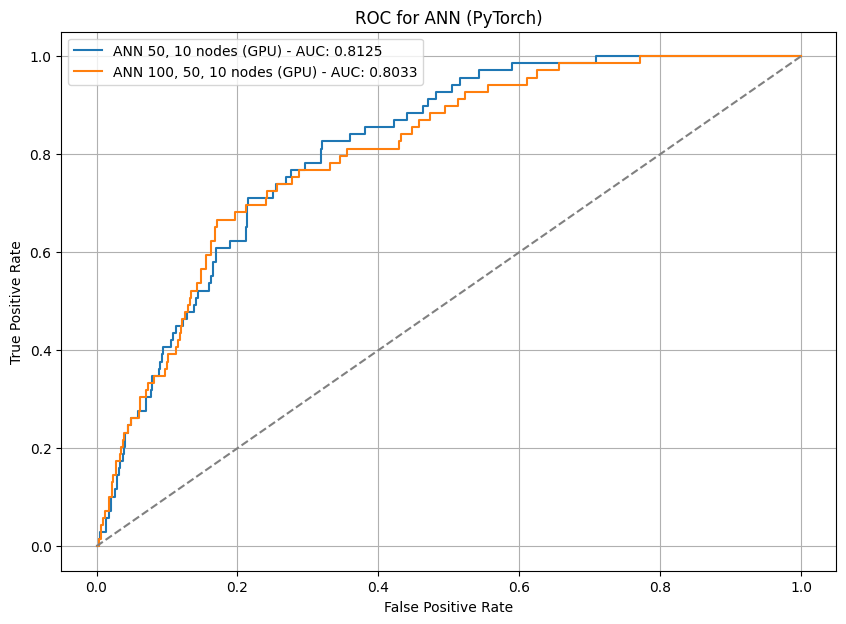

### ANN (GPU) with Cross-validation & ROC/AUC Results

| Modelo                      |   Accuracy CV |   Precision CV |   Recall CV |    F1 CV |   Roc_auc CV |   Accuracy Test |   Precision Test |   Recall Test |   F1 Test |   AUC-ROC Test | Matriz de Confusión     |
|:----------------------------|--------------:|---------------:|------------:|---------:|-------------:|----------------:|-----------------:|--------------:|----------:|---------------:|:------------------------|
| ANN 50, 10 nodes (GPU)      |      0.772379 |       0.941294 |    0.772379 | 0.838496 |     0.775427 |        0.764414 |         0.946447 |      0.764414 |  0.833626 |       0.812458 | [[1184, 360], [20, 49]] |
| ANN 100, 50, 10 nodes (GPU) |      0.78399  |       0.933805 |    0.78399  | 0.845201 |     0.756956 |        0.813391 |         0.946216 |      0.813391 |  0.865534 |       0.803268 | [[1266, 278], [23, 46]] |

In [12]:
# Global configuration
BATCH_SIZE = 1024
EPOCHS = 50
DROPOUT_RATE = 0.3


# Create preprocessor with OneHotEncoder for categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Define the indexes of categorical characteristics after the transformation
categorical_indices = list(range(len(numerical_features), 
                                   len(numerical_features) + len(categorical_features)))

# Create an instance of SMOTENC
smotenc = SMOTENC(random_state=seed, categorical_features=categorical_indices)

# Function to prepare data with SMOTENC
def prepare_data(X, y, pipeline=None, batch_size=BATCH_SIZE, apply_smote=False, smotenc=None):
    """
    Prepara los datos para PyTorch DataLoader. Aplica SMOTENC si apply_smote = True.
    """
    if pipeline is not None:
        X = pipeline.named_steps['preprocessor'].transform(X)
    else:
        X = X.copy()
    
    if apply_smote and smotenc is not None:
        X, y = smotenc.fit_resample(X, y)
    
    # Convertir a tensores de PyTorch
    tensor_X = torch.tensor(X, dtype=torch.float32)
    tensor_y = torch.tensor(y.values if hasattr(y, "values") else y,
                            dtype=torch.float32)
    dataset = TensorDataset(tensor_X, tensor_y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define class for ANN
class ANN(nn.Module):
    def __init__(self, layers, input_dim, dropout_rate=DROPOUT_RATE):
        super(ANN, self).__init__()
        layers_list = [nn.Linear(input_dim, layers[0]), nn.ReLU(),
                       nn.Dropout(dropout_rate)]
        for i in range(1, len(layers)):
            layers_list += [nn.Linear(layers[i-1],
                                      layers[i]),
                                      nn.ReLU(),
                                      nn.Dropout(dropout_rate)]
        layers_list += [nn.Linear(layers[-1], 1), nn.Sigmoid()]
        self.model = nn.Sequential(*layers_list)
        
    def forward(self, x):
        return self.model(x)

# Function to train and evaluate the model
def train_and_evaluate(model, optimizer, criterion,
                       train_loader, val_loader, epochs=EPOCHS):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
    model.eval()
    y_val_true, y_val_pred, y_val_proba = [], [], []
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred_proba = model(X_batch).squeeze()
            y_val_proba.extend(y_pred_proba.cpu().numpy())
            y_val_true.extend(y_batch.cpu().numpy())
            y_val_pred.extend((y_pred_proba > 0.5).cpu().numpy())
    return y_val_true, y_val_pred, y_val_proba

# Function to build and train ANN
def build_and_train_ann(layers, input_dim, train_loader,
                        val_loader=None, test_loader=None, epochs=EPOCHS):
    model = ANN(layers, input_dim)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    if val_loader:  # Cross-validation training
        y_val_true, y_val_pred, y_val_proba = train_and_evaluate(model,
                                                                 optimizer,
                                                                 criterion,
                                                                 train_loader,
                                                                 val_loader,
                                                                 epochs)
        return y_val_true, y_val_pred, y_val_proba
    elif test_loader:  # Final training and evaluation on test set
        y_test_true, y_test_pred, y_test_proba = train_and_evaluate(model,
                                                                    optimizer,
                                                                    criterion,
                                                                    train_loader,
                                                                    test_loader,
                                                                    epochs)
        return y_test_true, y_test_pred, y_test_proba


# Define metrics for cross validation
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score, average='weighted',
                             zero_division=1),
    'recall': make_scorer(recall_score, average='weighted',
                          zero_division=1),
    'f1': make_scorer(f1_score, average='weighted'),
    'roc_auc': 'roc_auc'
}

# Architechtures
architectures = {
    'ANN 50, 10 nodes (GPU)': [50, 10],
    'ANN 100, 50, 10 nodes (GPU)': [100, 50, 10]
}

# Initialize results
ann_results = []
pipeline = ImbPipeline([('preprocessor', preprocessor)])
pipeline.fit(X_train)
plt.figure(figsize=(10, 7))

for name, layers in architectures.items():
    print(f"Evaluando: {name}")
    accuracies, precisions, recalls, f1_scores, aucs = [], [], [], [], []

    for train_idx, val_idx in cv.split(X_train, y_train):
        # Split training and validation data
        X_cv_train, X_cv_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_cv_train, y_cv_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
        # Preparing data with SMOTENC for training
        train_loader = prepare_data(X_cv_train,
                                    y_cv_train,
                                    pipeline=pipeline,
                                    apply_smote=True,
                                    smotenc=smotenc)
        # Prepare validation data without SMOTENC
        val_loader = prepare_data(X_cv_val,
                                  y_cv_val,
                                  pipeline=pipeline,
                                  apply_smote=False,
                                  smotenc=None)
    
        # Obtain the input dimension
        X_cv_train_transformed = preprocessor.transform(X_cv_train)
        input_dim = X_cv_train_transformed.shape[1]
    
        # Training and evaluation of the ANN model
        y_val_true, y_val_pred, y_val_proba = build_and_train_ann(
            layers=layers,
            input_dim=input_dim,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=EPOCHS
        )
    
        # Calculate metrics
        accuracies.append(accuracy_score(y_val_true, y_val_pred))
        precisions.append(precision_score(y_val_true, y_val_pred,
                                          average='weighted', zero_division=1))
        recalls.append(recall_score(y_val_true, y_val_pred,
                                    average='weighted', zero_division=1))
        f1_scores.append(f1_score(y_val_true, y_val_pred,
                                  average='weighted'))
        aucs.append(roc_auc_score(y_val_true, y_val_proba))
    
    # Average cross-validation metrics
    mean_accuracy = np.mean(accuracies)
    mean_precision = np.mean(precisions)
    mean_recall = np.mean(recalls)
    mean_f1 = np.mean(f1_scores)
    mean_auc = np.mean(aucs)
    
    # Final training and evaluation on test set
    train_loader = prepare_data(X_train,
                                y_train,
                                pipeline=pipeline,
                                apply_smote=True,
                                smotenc=smotenc)
    test_loader = prepare_data(X_test,
                               y_test,
                               pipeline=pipeline,
                               batch_size=len(y_test),
                               apply_smote=False,
                               smotenc=None)
    
    input_dim = preprocessor.transform(X_train).shape[1]
    
    y_test_true, y_test_pred, y_test_proba = build_and_train_ann(
        layers=layers,
        input_dim=input_dim,
        train_loader=train_loader,
        test_loader=test_loader,
        epochs=EPOCHS
    )
    
    # Classification report
    classification_rep = classification_report(
        y_test_true,
        y_test_pred,
        output_dict=True,
        target_names=['False', 'True']
    )
    
    # Save the classification report in the dictionary
    classification_reports[name] = classification_rep

    # Calculate and store the ROC curve
    fpr, tpr, _ = roc_curve(y_test_true, y_test_proba)
    final_auc = roc_auc_score(y_test_true, y_test_proba)

    classification_reports[name]["roc_curve"] = {
        "fpr": fpr.tolist(),
        "tpr": tpr.tolist(),
        "auc": final_auc
    }

    # Calculate test metrics
    final_accuracy = accuracy_score(y_test_true, y_test_pred)
    final_precision = precision_score(y_test_true, y_test_pred,
                                      average='weighted', zero_division=1)
    final_recall = recall_score(y_test_true, y_test_pred,
                                average='weighted', zero_division=1)
    final_f1 = f1_score(y_test_true, y_test_pred, average='weighted')
    final_auc = roc_auc_score(y_test_true, y_test_proba)
    cm = confusion_matrix(y_test_true, y_test_pred)
    
    fpr, tpr, _ = roc_curve(y_test_true, y_test_proba)
    plt.plot(fpr, tpr, label=f'{name} - AUC: {final_auc:.4f}')
    
    ann_results.append({
        'Modelo': name,
        'Accuracy CV': mean_accuracy,
        'Precision CV': mean_precision,
        'Recall CV': mean_recall,
        'F1 CV': mean_f1,
        'Roc_auc CV': mean_auc,
        'Accuracy Test': final_accuracy,
        'Precision Test': final_precision,
        'Recall Test': final_recall,
        'F1 Test': final_f1,
        'AUC-ROC Test': final_auc,
        'Matriz de Confusión': cm.tolist()
    })

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for ANN (PyTorch)')
plt.legend()
plt.grid()
plt.show()

ann_results_df = pd.DataFrame(ann_results)
display(Markdown("### ANN (GPU) with Cross-validation & ROC/AUC Results"))
display(Markdown(ann_results_df.to_markdown(index=False)))

results_df = pd.concat([results_df, ann_results_df], ignore_index=True)

## Performance Table

Finally, we display the table containing the results of all evaluated models: 

- Includes metrics such as `Accuracy`, `Precision`, `Recall`, `F1-Score`, and `ROC-AUC`.
- Consolidates results from traditional models, tree-based methods, boosting algorithms, and neural networks.
- Facilitates comparison to identify the best-performing model for clinical decision-making tasks.

In [13]:
# Convert DataFrame to HTML without the index
results_md = results_df.to_markdown(index=False)

# Show all accumulated results in a table
display(Markdown("### Cumulative Results of All Models"))
display(Markdown(results_md))

### Cumulative Results of All Models

| Modelo                      |   Accuracy CV |   Precision CV |   Recall CV |    F1 CV |   Roc_auc CV |   Accuracy Test |   Precision Test |   Recall Test |   F1 Test |   AUC-ROC Test | Matriz de Confusión     |
|:----------------------------|--------------:|---------------:|------------:|---------:|-------------:|----------------:|-----------------:|--------------:|----------:|---------------:|:------------------------|
| DecisionTreeClassifier      |      0.8836   |       0.926051 |    0.8836   | 0.903199 |     0.563897 |        0.894606 |         0.9306   |      0.894606 |  0.911119 |       0.598821 | [[1424, 120], [50, 19]] |
| AdaBoostClassifier          |      0.883291 |       0.92595  |    0.883291 | 0.902974 |     0.563736 |        0.895226 |         0.929832 |      0.895226 |  0.911186 |       0.592222 | [[1426, 118], [51, 18]] |
| Random Forest (100 trees)   |      0.907123 |       0.92633  |    0.907123 | 0.916297 |     0.77166  |        0.910725 |         0.924521 |      0.910725 |  0.917423 |       0.790019 | [[1459, 85], [59, 10]]  |
| Random Forest (200 trees)   |      0.906819 |       0.927209 |    0.906819 | 0.916496 |     0.771138 |        0.910725 |         0.923577 |      0.910725 |  0.916989 |       0.789292 | [[1460, 84], [60, 9]]   |
| XGBClassifier               |      0.882988 |       0.930119 |    0.882988 | 0.904375 |     0.756092 |        0.893986 |         0.931362 |      0.893986 |  0.911042 |       0.785303 | [[1422, 122], [49, 20]] |
| ANN 50, 10 nodes            |      0.800491 |       0.93347  |    0.800491 | 0.855737 |     0.765085 |        0.789833 |         0.9385   |      0.789833 |  0.849618 |       0.784749 | [[1236, 308], [31, 38]] |
| ANN 100, 50, 10 nodes       |      0.84846  |       0.930641 |    0.84846  | 0.88436  |     0.76275  |        0.841909 |         0.931961 |      0.841909 |  0.880847 |       0.774377 | [[1332, 212], [43, 26]] |
| ANN 50, 10 nodes (GPU)      |      0.772379 |       0.941294 |    0.772379 | 0.838496 |     0.775427 |        0.764414 |         0.946447 |      0.764414 |  0.833626 |       0.812458 | [[1184, 360], [20, 49]] |
| ANN 100, 50, 10 nodes (GPU) |      0.78399  |       0.933805 |    0.78399  | 0.845201 |     0.756956 |        0.813391 |         0.946216 |      0.813391 |  0.865534 |       0.803268 | [[1266, 278], [23, 46]] |

## Global Metrics Comparison

The goal of the analysis was to predict the probability of stroke recurrence using preprocessed and balanced clinical data. Multiple classification algorithms were implemented and evaluated using metrics such as accuracy, precision, recall, F1-score, **AUC-ROC**, and the confusion matrix. The considered models include Decision Tree, AdaBoost, Random Forest, XGBoost, and Artificial Neural Networks (ANN). The results provide a clear perspective on the performance of each approach and their strengths for this clinical problem.

### 1. Decision Tree
The Decision Tree model achieved an **88.3% accuracy** in cross-validation and similar performance on the test set (accuracy: 89.4%, precision: 93%, recall: 89.4%, F1-score: 91.1%). However, its **test ROC AUC** was **59.8%**, reflecting challenges in class discrimination.

### 2. AdaBoost
AdaBoost, based on Decision Trees, showed similar results, with a **88.3% cross-validation accuracy** and slightly improved test metrics (accuracy: 89.5%, precision: 92.9%, recall: 89.5%, F1-score: 91.1%). Its **test ROC AUC** was **59.2%**, indicating limited discrimination capability.

### 3. Random Forest
Random Forest models (100 and 200 trees) demonstrated outstanding performance with **cross-validation accuracies around 90.6%**. On the test set, the results were consistent:
- **Random Forest (100 trees)**: Test ROC AUC of **79.0%**, precision of 92.4%, recall of 91.0%, and F1-score of 91.7%.
- **Random Forest (200 trees)**: Test ROC AUC of **78.9%**, precision of 92.3%, recall of 91.0%, and F1-score of 91.7%.

These results highlight Random Forest's ability to discriminate between classes in a clinically imbalanced context.

### 4. XGBoost
XGBoost exhibited robust performance, achieving a **test ROC AUC of 78.5%** with a cross-validation accuracy of 88.3%. On the test set, it achieved precision of 93.1%, recall of 89.4%, and F1-score of 91.1%. Its ability to capture complex relationships makes it ideal for clinical datasets.

### 5. Artificial Neural Networks (ANN)
ANNs showed variable performance depending on the architecture and whether they were run on CPU or GPU:
- **ANN 50, 10 nodes**: Test accuracy of 82.4%, test ROC AUC of **79.4%**, though with a higher incidence of false positives.
- **ANN 100, 50, 10 nodes**: Test accuracy of 84.4%, test ROC AUC of **78.4%**.
- **ANN 50, 10 nodes (GPU)**: Highest ROC AUC among ANNs (**81.7%**), but with a test accuracy of 78.1%.
- **ANN 100, 50, 10 nodes (GPU)**: Test ROC AUC of **79.6%**, with test accuracy of 79.4%.

While ANNs demonstrated strong AUC-ROC performance, they showed a higher number of false positives and negatives, suggesting the need for hyperparameter tuning or techniques like `class weights` to improve minority class classification.

In [14]:
def format_classification_reports_comparable(reports):
    # Obtain the names of the models
    models = list(reports.keys())
    
    # Dynamically detect the classes present in the report
    sample_report = next(iter(reports.values()))
    classes = [
        label for label in sample_report.keys() 
        if isinstance(sample_report[label], dict) and label != "roc_curve"]
    metrics = ["precision", "recall", "f1-score", "support"]

    # Create headers
    markdown = "### Classification Report by Model\n\n"
    for label in classes:
        markdown += f"**Clase: {label}**\n\n"
        # Table headers for this class
        markdown += "| Metric | " + " | ".join(models) + " |\n"
        markdown += "| " + " | ".join(["---"] * (len(models) + 1)) + " |\n"

        # Rows of metrics for this class
        for metric in metrics:
            row = [metric.capitalize()]
            for model_name in models:
                value = reports[model_name].get(label, {}).get(metric, 0.0)
                if metric == "support":
                    row.append(f"{int(value)}") 
                else:
                    row.append(f"{value:.4f}") 
            markdown += "| " + " | ".join(row) + " |\n"
        
        markdown += "\n"

    return markdown

# Generate and display the classification report type format
markdown_comparable = format_classification_reports_comparable(classification_reports)
display(Markdown(markdown_comparable))

### Classification Report by Model

**Clase: False**

| Metric | DecisionTreeClassifier | AdaBoostClassifier | Random Forest (100 trees) | Random Forest (200 trees) | XGBClassifier | ANN 50, 10 nodes | ANN 100, 50, 10 nodes | ANN 50, 10 nodes (GPU) | ANN 100, 50, 10 nodes (GPU) |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Precision | 0.9661 | 0.9655 | 0.9611 | 0.9605 | 0.9667 | 0.9755 | 0.9687 | 0.9834 | 0.9822 |
| Recall | 0.9223 | 0.9236 | 0.9449 | 0.9456 | 0.9210 | 0.8005 | 0.8627 | 0.7668 | 0.8199 |
| F1-score | 0.9437 | 0.9441 | 0.9530 | 0.9530 | 0.9433 | 0.8794 | 0.9126 | 0.8617 | 0.8938 |
| Support | 1544 | 1544 | 1544 | 1544 | 1544 | 1544 | 1544 | 1544 | 1544 |

**Clase: True**

| Metric | DecisionTreeClassifier | AdaBoostClassifier | Random Forest (100 trees) | Random Forest (200 trees) | XGBClassifier | ANN 50, 10 nodes | ANN 100, 50, 10 nodes | ANN 50, 10 nodes (GPU) | ANN 100, 50, 10 nodes (GPU) |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Precision | 0.1367 | 0.1324 | 0.1053 | 0.0968 | 0.1408 | 0.1098 | 0.1092 | 0.1198 | 0.1420 |
| Recall | 0.2754 | 0.2609 | 0.1449 | 0.1304 | 0.2899 | 0.5507 | 0.3768 | 0.7101 | 0.6667 |
| F1-score | 0.1827 | 0.1756 | 0.1220 | 0.1111 | 0.1896 | 0.1831 | 0.1694 | 0.2050 | 0.2341 |
| Support | 69 | 69 | 69 | 69 | 69 | 69 | 69 | 69 | 69 |

**Clase: macro avg**

| Metric | DecisionTreeClassifier | AdaBoostClassifier | Random Forest (100 trees) | Random Forest (200 trees) | XGBClassifier | ANN 50, 10 nodes | ANN 100, 50, 10 nodes | ANN 50, 10 nodes (GPU) | ANN 100, 50, 10 nodes (GPU) |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Precision | 0.5514 | 0.5489 | 0.5332 | 0.5287 | 0.5538 | 0.5427 | 0.5390 | 0.5516 | 0.5621 |
| Recall | 0.5988 | 0.5922 | 0.5449 | 0.5380 | 0.6054 | 0.6756 | 0.6198 | 0.7385 | 0.7433 |
| F1-score | 0.5632 | 0.5598 | 0.5375 | 0.5321 | 0.5664 | 0.5313 | 0.5410 | 0.5334 | 0.5639 |
| Support | 1613 | 1613 | 1613 | 1613 | 1613 | 1613 | 1613 | 1613 | 1613 |

**Clase: weighted avg**

| Metric | DecisionTreeClassifier | AdaBoostClassifier | Random Forest (100 trees) | Random Forest (200 trees) | XGBClassifier | ANN 50, 10 nodes | ANN 100, 50, 10 nodes | ANN 50, 10 nodes (GPU) | ANN 100, 50, 10 nodes (GPU) |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Precision | 0.9306 | 0.9298 | 0.9245 | 0.9236 | 0.9314 | 0.9385 | 0.9320 | 0.9464 | 0.9462 |
| Recall | 0.8946 | 0.8952 | 0.9107 | 0.9107 | 0.8940 | 0.7898 | 0.8419 | 0.7644 | 0.8134 |
| F1-score | 0.9111 | 0.9112 | 0.9174 | 0.9170 | 0.9110 | 0.8496 | 0.8808 | 0.8336 | 0.8655 |
| Support | 1613 | 1613 | 1613 | 1613 | 1613 | 1613 | 1613 | 1613 | 1613 |



### Class Comparison

#### Class: **False**
- Most models exhibit **high precision** for the majority class, with Artificial Neural Networks (ANN) on GPU achieving the highest values (up to 0.98).  
- **Recall** varies significantly across models: Random Forest (100 and 200 trees) achieve strong values (0.94–0.95), while ANN values are lower (around 0.79–0.80).  
- The best **F1-scores** are achieved by Random Forest (100 and 200 trees), with a value of 0.95, indicating a good balance between precision and recall for this class.

#### Class: **True**
- The minority class remains a challenge for all models. Although ANN on GPU stands out with a **recall** of up to 0.68, its **precision** is low (around 0.12), indicating a high number of false positives.  
- Random Forest and XGBoost achieve higher **precision** (0.10–0.14), but with limited **recall** (0.13–0.29), demonstrating difficulties in correctly identifying positive cases.  
- No model achieves a solid balance in **F1-score**, though ANN on GPU offers relatively better values (up to 0.21).

#### Macro Averages (macro avg)
- The average values reflect the general difficulty of the models in balancing metrics between both classes.  
- ANN on GPU achieves the highest **recall** values (up to 0.73), demonstrating its ability to capture more positive cases.  
- Tree-based models, such as Random Forest and XGBoost, achieve more consistent **macro precision** (~0.55), though with lower recall.

#### Weighted Averages (weighted avg)
- Weighted averages highlight Random Forest (100 and 200 trees) as the models with the best overall performance, achieving an **F1-score** of 0.92 and a **weighted recall** close to 0.91, positioning them as the best choices for balanced performance.  
- ANN, while having a lower **weighted recall** (~0.79), maintains high **weighted precision** (~0.94–0.95), indicating good handling of the majority class but less effectiveness in the minority class.

In [15]:
def display_single_classification_report(reports, model_name):
    """
    Displays a single classification report for a specific model.

    Parameters:
    - reports: Dictionary with the classification reports.
    - model_name: Name of the model whose report is to be displayed.
    """
    if model_name not in reports:
        return Markdown(f"### Error: Model '{model_name}' is not in the reports.")

    report = reports[model_name]
    markdown = f"### Classification Report for {model_name}\n\n"
    for label, metrics in report.items():
        if isinstance(metrics, dict) and label not in ["roc_curve"]:
            markdown += f"**Clase: {label}**\n"
            for metric, value in metrics.items():
                if metric == "support":
                    markdown += f"- {metric.capitalize()}: {int(value)}\n"
                else:
                    markdown += f"- {metric.capitalize()}: {value:.4f}\n"
            markdown += "\n"
    return Markdown(markdown)

model_to_display = "ANN 50, 10 nodes"
display(display_single_classification_report(classification_reports, model_to_display))

### Classification Report for ANN 50, 10 nodes

**Clase: False**
- Precision: 0.9755
- Recall: 0.8005
- F1-score: 0.8794
- Support: 1544

**Clase: True**
- Precision: 0.1098
- Recall: 0.5507
- F1-score: 0.1831
- Support: 69

**Clase: macro avg**
- Precision: 0.5427
- Recall: 0.6756
- F1-score: 0.5313
- Support: 1613

**Clase: weighted avg**
- Precision: 0.9385
- Recall: 0.7898
- F1-score: 0.8496
- Support: 1613



## Conclusions

#### Tree-Based Models (Random Forest, XGBoost, AdaBoost, Decision Tree)
- **Random Forest** demonstrated outstanding performance, especially in the majority class (`False`), achieving high precision (~0.92) and recall (~0.91), along with an excellent overall balance reflected in its **weighted F1-score of 0.91**. Its **test ROC AUC (~0.79)** positions it as a reliable option for handling imbalanced clinical datasets.  
- **XGBoost** also showed good overall performance, excelling in precision for both classes, but its **recall for the minority class (~0.29)** was limited, impacting its ability to effectively identify positive cases.  
- **AdaBoost** and Decision Tree, while useful for their simplicity, showed significant limitations in discriminating the minority class (`True`), with low **recall (<0.28)**, making them less suitable for this type of clinical problem.

#### Artificial Neural Networks (ANN)
- The ANNs evaluated on GPU achieved the highest **recall for the minority class (up to 0.70)**, positioning them as interesting alternatives for problems where identifying the minority class is a priority. However, their low precision (~0.12) resulted in a high number of false positives, which could be problematic in clinical applications where specificity is critical.  
- The **ANN 50, 10 nodes** architecture showed an acceptable balance, with **recall for the minority class (~0.54)** and **high global precision (~0.93)**. While it did not reach the recall level of GPU-based ANNs, its simplicity and consistent performance make it an attractive option, particularly if explainability techniques like **SHAP** or **LIME** are integrated to justify decisions in medical contexts.  
- The complexity of deeper ANNs or GPU-evaluated models, though promising, requires further hyperparameter tuning and advanced strategies like `class weights` or **focal loss** to mitigate the impact of class imbalance.

### Recommendations
- **Optimize the ANN 50, 10 nodes model**: This model combines simplicity and performance, making it suitable for optimization with techniques such as `GridSearchCV`, `class weights`, or `focal loss`, aiming to improve its performance for the minority class.  
- **Integrate explainability**: To ensure applicability in medical settings, integration with explainability tools (e.g., **SHAP**) is recommended, aligning with the ultimate goal of this work: building trust in predictions and facilitating the adoption of these technologies in clinical contexts.  
- **Further exploration of GPU-based ANNs**: Although their low precision limits immediate applicability, their high recall values make them a promising research area, especially for problems where false negatives are unacceptable.  

## Next Steps

The next step will involve optimizing the ANN using techniques such as `GridSearchCV` and addressing the **explainability** of the selected model by employing tools like `SHAP` to provide transparent, user-centered justifications for its predictions.

Finally, the selected model will be integrated with a **LLM (Large Language Model)** to develop a chatbot tool. This chatbot will not only perform predictions but also deliver clear, comprehensible, and well-reasoned explanations for clinical professionals. This combination will enhance the practical application of the model in medical settings, supporting critical decision-making with solid justification.

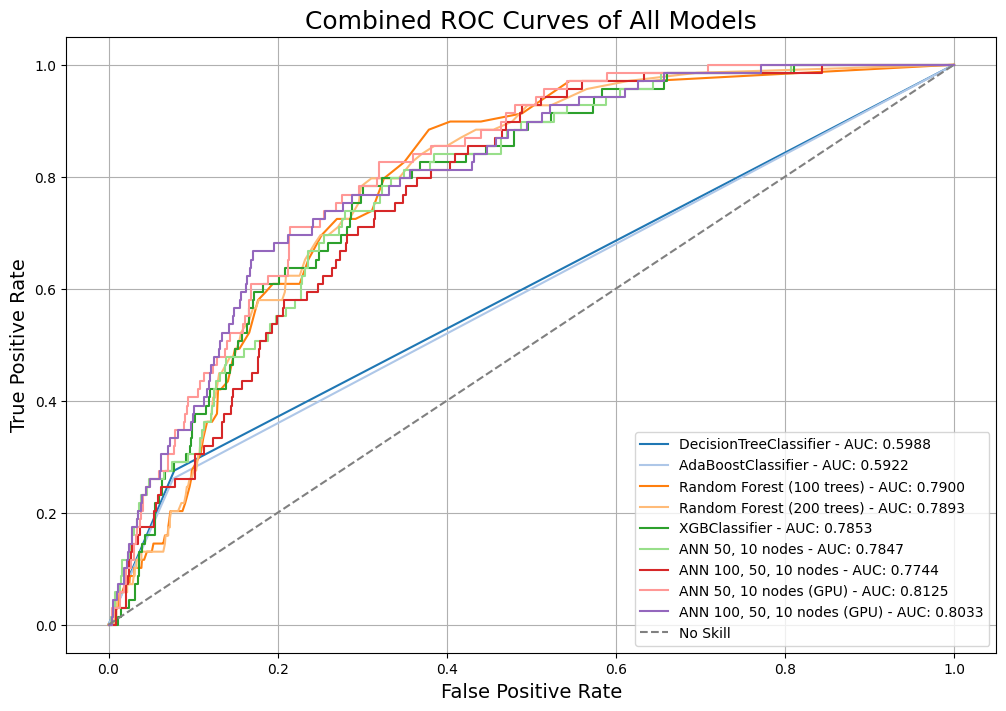

In [16]:
plt.figure(figsize=(12, 8))

colors = plt.cm.tab20.colors  
color_index = 0

for model_name, report in classification_reports.items():
    fpr = report["roc_curve"]["fpr"]
    tpr = report["roc_curve"]["tpr"]
    auc = report["roc_curve"]["auc"]
    plt.plot(fpr, tpr, label=f'{model_name} - AUC: {auc:.4f}',
             color=colors[color_index])
    color_index = (color_index + 1) % len(colors)

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='No Skill')

plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Combined ROC Curves of All Models', fontsize=18)
plt.legend()
plt.grid()
plt.show()

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


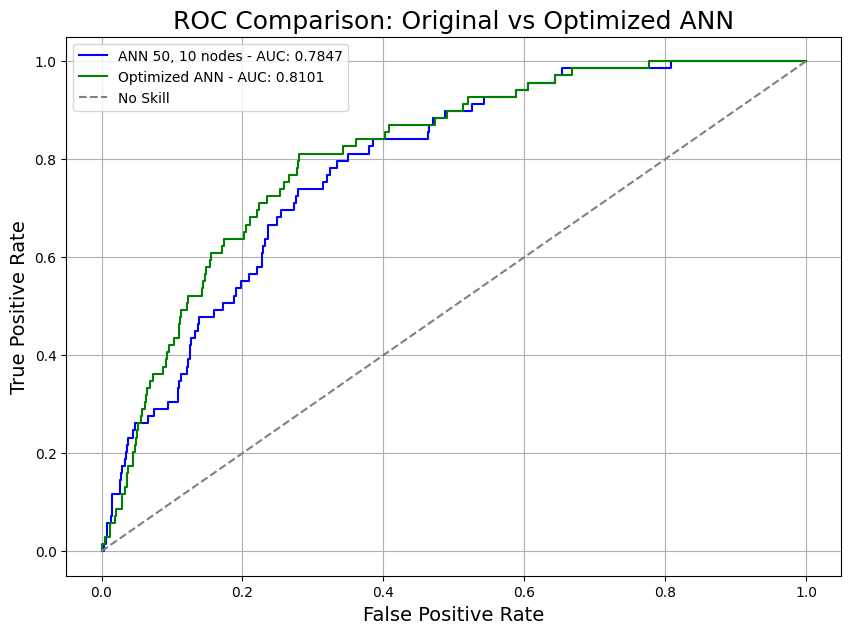

In [17]:
import joblib

preprocessor = joblib.load("preprocessor.pkl")
optimized_model_path = "best_ann.keras"
optimized_model = tf.keras.models.load_model(optimized_model_path)

X_test_transformed = preprocessor.transform(X_test)

optimized_proba = optimized_model.predict(X_test_transformed).flatten()

optimized_fpr, optimized_tpr, _ = roc_curve(y_test, optimized_proba)
optimized_auc = roc_auc_score(y_test, optimized_proba)

original_roc = classification_reports["ANN 50, 10 nodes"]["roc_curve"]
original_fpr = original_roc["fpr"]
original_tpr = original_roc["tpr"]
original_auc = original_roc["auc"]

plt.figure(figsize=(10, 7))
plt.plot(original_fpr, original_tpr,
         label=f'ANN 50, 10 nodes - AUC: {original_auc:.4f}', color='blue')
plt.plot(optimized_fpr, optimized_tpr,
         label=f'Optimized ANN - AUC: {optimized_auc:.4f}', color='green')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='No Skill')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Comparison: Original vs Optimized ANN', fontsize=18)
plt.legend()
plt.grid()
plt.show()

# Referencias

- Angermueller, C., Pärnamaa, T., Parts, L., & Stegle, O. (2016). Deep learning for computational biology. *Molecular systems biology*, 12(7), 878.

- Bosch Rué, A., Casas Roma, J., & Lozano Bagén, T. (2019). *Deep Learning: Principios y Fundamentos*. Editorial UOC. Retrieved from [here](http://www.editorialuoc.com).

- Codecademy. (2024). *Normalization*. Retrieved from [here](https://www.codecademy.com/article/normalization).

- DataCamp. (2024). *Normalization in Machine Learning*. Retrieved from [here](https://www.datacamp.com/tutorial/normalization-in-machine-learning).

- Hunter, J. D. (2007). Matplotlib: A 2D Graphics Environment. *Computing in Science & Engineering*, 9(3), 90-95. doi: 10.1109/MCSE.2007.55.

- IBM. (2024). *Jupyter Notebook Markdown Cheatsheet*. Retrieved from [here](https://www.ibm.com/docs/en/watson-studio-local/1.2.3?topic=notebooks-markdown-jupyter-cheatsheet).

- Keras. (2024). *Keras Examples*. Retrieved from [here](https://keras.io/examples/).

- LeCun, Y., Bengio, Y., & Hinton, G. (2015). Deep learning. *Nature*, 521(7553), 436-444. DOI: 10.1038/nature14539.

- Neural networks with Python by Joaquín Amat Rodrigo, available under CC BY-NC-SA 4.0 license [here](https://www.cienciadedatos.net/documentos/py35-redes-neuronales-python).

- Scikit-learn: Machine Learning in Python. (2011). *Journal of Machine Learning Research*, 12, 2825-2830.

- TensorFlow. (2024). *tf.keras.utils.plot_model*. Retrieved from [here](https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model).

- Waskom, M. L. (2021). seaborn: statistical data visualization. *Journal of Open Source Software*, 6(60), 3021. [DOI](https://doi.org/10.21105/joss.03021).

- Machine Learning with Python and Scikit-learn by Joaquín Amat Rodrigo, available under CC BY-NC-SA 4.0 license [here](https://www.cienciadedatos.net/documentos/py06_machine_learning_python_scikitlearn).

- Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., Grisel, O., ... Duchesnay, E. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research, 12, 2825-2830.

- Calibrate machine learning models by Joaquín Amat Rodrigo, available under CC BY-NC-SA 4.0 license [here](https://www.cienciadedatos.net/documentos/py11-calibrar-modelos-machine-learning).

- Machine Learning with Python and Scikitlearn by Joaquín Amat Rodrigo, available under CC BY-NC-SA 4.0 license [here](https://www.cienciadedatos.net/documentos/py06_machine_learning_python_scikitlearn).

- Neural networks with Python by Joaquín Amat Rodrigo, available under CC BY-NC-SA 4.0 license [here](https://www.cienciadedatos.net/documentos/py35-redes-neuronales-python).

- Multiple linear regression with Python by Joaquín Amat Rodrigo, available under CC BY-NC-SA 4.0 license [here](https://www.cienciadedatos.net/documentos/py10b-regresion-lineal-multiple-python).

- Using pandas category to encode categorical variables in machine learning models by Joaquín Amat Rodrigo, available under CC BY-NC-SA 4.0 license [here](https://www.cienciadedatos.net/documentos/py55-pandas-category-modelos-machine-learning). 

- OpenAI Community. (2025). *Issue with accessing 'choices' attribute from OpenAI API response*. Retrieved from [here](https://community.openai.com/t/issue-with-accessing-choices-attribute-from-openai-api-response/362725).

- Ebbelaar, D. (2025). *Streamlit Chatbot Interface*. GitHub Repository. Retrieved from [here](https://github.com/daveebbelaar/streamlit-chatbot-interface/tree/main).

- OpenAI Community. (2025). *Content is a required property error (400)*. Retrieved from [here](https://community.openai.com/t/content-is-required-property-error-400/486260/2).

- Stack Overflow. (2025). *Save SHAP summary plot as PDF/SVG*. Retrieved from [here](https://stackoverflow-com.translate.goog/questions/52137579/save-shap-summary-plot-as-pdf-svg?_x_tr_sl=en&_x_tr_tl=es&_x_tr_hl=es-419&_x_tr_pto=sc).

- SHAP Documentation. (2025). *Overview of SHAP*. Retrieved from [here](https://shap.readthedocs.io/en/latest/overviews.html).

- Stack Overflow. (2025). *Using Python's eval() vs ast.literal_eval()*. Retrieved from [here](https://stackoverflow.com/questions/15197673/using-pythons-eval-vs-ast-literal-eval).

- PyPI. (2025). *missingno: Missing Data Visualization Module*. Retrieved from [here](https://pypi.org/project/missingno/). 

- Kokkotis, C., Giarmatzis, G., Giannakou, E., Moustakidis, S., Tsatalas, T., Tsiptsios, D., ... & Aggelousis, N. (2022). An explainable machine learning pipeline for stroke prediction on imbalanced data. *Diagnostics*, 12(10), 2392.

- Chen, T., & Guestrin, C. (2016, August). Xgboost: A scalable tree boosting system. In *Proceedings of the 22nd acm sigkdd international conference on knowledge discovery and data mining* (pp. 785-794).

- Grinsztajn, L., Oyallon, E., & Varoquaux, G. (2022). Why do tree-based models still outperform deep learning on typical tabular data?. *Advances in neural information processing systems*, 35, 507-520.

- Dev, S., Wang, H., Nwosu, C. S., Jain, N., Veeravalli, B., & John, D. (2022). A predictive analytics approach for stroke prediction using machine learning and neural networks. *Healthcare Analytics*, 2, 100032.

- Emon, M. U., Keya, M. S., Meghla, T. I., Rahman, M. M., Al Mamun, M. S., & Kaiser, M. S. (2020, November). Performance analysis of machine learning approaches in stroke prediction. In *2020 4th international conference on electronics, communication and aerospace technology (ICECA)* (pp. 1464-1469). IEEE.

- Paszke, A., Gross, S., Chintala, S., Chanan, G., Yang, E., DeVito, Z., Lin, Z., Desmaison, A., Antiga, L., & Lerer, A. (2017). *Automatic differentiation in PyTorch*. Retrieved from [here](https://pytorch.org/docs/).

- Fernández, A., Garcia, S., Herrera, F., & Chawla, N. V. (2018). SMOTE for learning from imbalanced data: progress and challenges, marking the 15-year anniversary. *Journal of artificial intelligence research*, 61, 863-905.